In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle #.
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from tensorflow.keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-l7l7vjf4 because the default path (/home/abriza/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


<div class="alert alert-success">
    
* Original parent directory: "../../storage/"
* Implemented parent directory: "./" 
</div>

In [2]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "./image_caption/dataset/TextFiles/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [3]:
#.
type(doc), len(doc)

(str, 3395237)

In [4]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [5]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [8]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [9]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [10]:
#. show image


In [11]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [12]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [13]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [14]:
#.
!head descriptions.txt

1000268201_693b08cb0e child in pink dress is climbing up set of stairs in an entry way
1000268201_693b08cb0e girl going into wooden building
1000268201_693b08cb0e little girl climbing into wooden playhouse
1000268201_693b08cb0e little girl climbing the stairs to her playhouse
1000268201_693b08cb0e little girl in pink dress going into wooden cabin
1001773457_577c3a7d70 black dog and spotted dog are fighting
1001773457_577c3a7d70 black dog and tricolored dog playing with each other on the road
1001773457_577c3a7d70 black dog and white dog with brown spots are staring at each other in the street
1001773457_577c3a7d70 two dogs of different breeds looking at each other on the road
1001773457_577c3a7d70 two dogs on pavement moving toward each other


In [15]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = './image_caption/dataset/TextFiles/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [16]:
#. train is a set of photo identifiers
list(train)[:5]

['3658733605_fbcf570843',
 '1289142574_2bd6a082dd',
 '3206999917_e682672cbc',
 '2713897716_c8cd610360',
 '105342180_4d4a40b47f']

In [17]:
# Below path contains all the images
images = './image_caption/dataset/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [18]:
#.
type(img), len(img), img[:3]

(list,
 8091,
 ['./image_caption/dataset/Flicker8k_Dataset/1053804096_ad278b25f1.jpg',
  './image_caption/dataset/Flicker8k_Dataset/110595925_f3395c8bd6.jpg',
  './image_caption/dataset/Flicker8k_Dataset/1236951314_0308dc4138.jpg'])

In [19]:
# Below file contains the names of images to be used in train data
train_images_file = './image_caption/dataset/TextFiles/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [20]:
#. 
len(train_img), train_img[:3]

(6000,
 ['./image_caption/dataset/Flicker8k_Dataset/1053804096_ad278b25f1.jpg',
  './image_caption/dataset/Flicker8k_Dataset/110595925_f3395c8bd6.jpg',
  './image_caption/dataset/Flicker8k_Dataset/1236951314_0308dc4138.jpg'])

In [21]:
# Below file conatins the names of images to be used in test data
test_images_file = './image_caption/dataset/TextFiles/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [22]:
#. 
len(test_img), test_img[:3]

(1000,
 ['./image_caption/dataset/Flicker8k_Dataset/2073105823_6dacade004.jpg',
  './image_caption/dataset/Flicker8k_Dataset/2682382530_f9f8fd1e89.jpg',
  './image_caption/dataset/Flicker8k_Dataset/279728508_6bd7281f3c.jpg'])

In [23]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [24]:
type(train_descriptions), list(train_descriptions.keys())[0], list(train_descriptions.values())[0]

(dict,
 '1000268201_693b08cb0e',
 ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'])

<div class="alert alert-success">
Note the addition of 'startseq' and 'endseq' in each description/caption
</div>

In [25]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [26]:
#. preprocess a sample image
sample_x = preprocess('./image_caption/dataset/Flicker8k_Dataset/2073105823_6dacade004.jpg')
type(sample_x), sample_x.shape

(numpy.ndarray, (1, 299, 299, 3))

<div class="alert alert-success">
Not sure why axis has to be expanded
</div>

## Transfer Learning Via Inception

In [27]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

2022-03-14 17:26:43.384837: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-14 17:26:43.384886: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-03-14 17:26:43.385150: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


![Inception](https://miro.medium.com/max/1400/1*9VoYufkvd-hBxK3p2NEWmw.png)

In [28]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output) #. get output of the 2nd to the last layer

In [60]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image #. get matrix representation of image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [ ]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    #. images is the parent path of all image files; img[len(images):] is the identifier for the image 'img'
    encoding_train[img[len(images):]] = encode(img) 
print("Time taken in seconds =", time()-start)

In [ ]:
type(encoding_train), list(encoding_train.keys())[:3]

In [ ]:
k = list(encoding_train.keys())[0] #. get first key
encoding_train[k], encoding_train[k].shape

In [ ]:
# Save the bottleneck train features to disk
with open("./image_caption/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [61]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 119.76768565177917


In [62]:
# Save the bottleneck test features to disk
with open("./image_caption/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

<div class="alert alert-success">
Load saved encoding
</div>

In [29]:
train_features = load(open("./image_caption/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [30]:
#.
type(train_features), list(train_features.keys())[:3]

(dict,
 ['1053804096_ad278b25f1.jpg',
  '110595925_f3395c8bd6.jpg',
  '1236951314_0308dc4138.jpg'])

In [31]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

<div class="alert alert-success">
3000 = 6000 images * 5 captions/image
</div>

In [32]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


### <font style="color:green">Create dictionaries for word <--> index conversion</font>

In [33]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [34]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

### <font style="color:green">Compute maximum length (number of words) of captions</font>

In [35]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [36]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [38]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator_tuple2(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield ((array(X1), array(X2)), array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [40]:
# Load Glove vectors
glove_dir = './glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [41]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:  #. unused variable max_words
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [42]:
embedding_matrix.shape

(1652, 200)

In [43]:
print(list(wordtoix.keys())[:25])

['startseq', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'way', 'endseq', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'the', 'to', 'her', 'black', 'dog']


In [44]:
e1, e2, e3 = embeddings_index.get('startseq'), embeddings_index.get('endseq'), embeddings_index.get('child')
e1, e2, e3.shape, e3[-20:], 

(None,
 None,
 (200,),
 array([ 1.2631  , -0.40756 , -0.12467 , -0.16687 , -0.57797 , -0.29546 ,
         0.051005, -0.065237,  0.11431 ,  0.15512 , -0.5127  , -0.58248 ,
         0.19001 ,  0.42882 ,  0.13797 , -0.93658 ,  0.12788 , -0.55435 ,
        -0.57478 , -0.013045], dtype=float32))

In [45]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [46]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [47]:
model.layers[2]

<div class="alert alert-success">
set embedding layer for image as nontrainable
</div>

In [48]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [49]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [50]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [51]:
for i in range(epochs):
    generator = data_generator_tuple2(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5') #. no need to save

/home/phd/abriza/.conda/envs/dla2/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-03-14 17:27:54.504217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2000/2000 [==============================] - 386s 193ms/step - loss: 2.7294


In [53]:
for i in range(epochs):
    generator = data_generator_tuple2(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')  #. no need to save

2000/2000 [==============================] - 384s 192ms/step - loss: 2.5383


In [54]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [55]:
for i in range(epochs):
    generator = data_generator_tuple2(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

1000/1000 [==============================] - 260s 260ms/step - loss: 2.3849


In [56]:
model.save_weights('./model_weights/model_30.h5')

<div class="alert alert-success">
Load the saved weights
</div>

In [57]:
model.load_weights('./model_weights/model_30.h5')

In [58]:
images = './image_caption/dataset/Flicker8k_Dataset/' #. parent directory of images

In [63]:
with open("./image_caption/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [64]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [67]:
#. initialize z as index to our images
z = -1

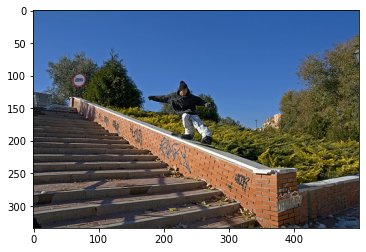

Greedy: man and woman sit on bench


In [68]:
z+=1  #.get next image
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

<div class="alert alert-success">
<h2>Implement Bleu to Evaluate Caption Effectiveness</h2>
</div>

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

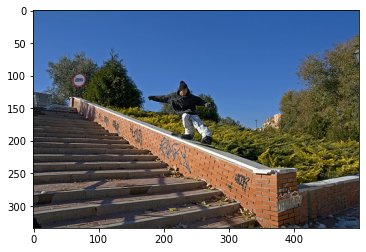

In [101]:
z = 0
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)

In [102]:
image_filename = list(encoding_test.keys())[z]
image_id = image_filename[:-4]
image_id

'2073105823_6dacade004'

In [103]:
captions = descriptions[image_id]
captions

['man in black hoodie and jeans skateboards down railing',
 'man skateboards down steep railing next to some steps',
 'person is sliding down brick rail on snowboard',
 'person walks down the brick railing near set of steps',
 'snowboarder rides down handrail without snow']

In [104]:
refs = [caption.split(' ') for caption in captions]
print(refs)

[['man', 'in', 'black', 'hoodie', 'and', 'jeans', 'skateboards', 'down', 'railing'], ['man', 'skateboards', 'down', 'steep', 'railing', 'next', 'to', 'some', 'steps'], ['person', 'is', 'sliding', 'down', 'brick', 'rail', 'on', 'snowboard'], ['person', 'walks', 'down', 'the', 'brick', 'railing', 'near', 'set', 'of', 'steps'], ['snowboarder', 'rides', 'down', 'handrail', 'without', 'snow']]


In [105]:
model_caption = greedySearch(image)
model_caption

'man and woman sit on bench'

In [109]:
candidate = model_caption.split(' ')
candidate

['man', 'and', 'woman', 'sit', 'on', 'bench']

In [ ]:
bleu_score = sentence_bleu(refs, candidate)
print(bleu_score)

In [ ]:
# two references for one document
references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
candidates = [['this', 'is', 'a', 'test']]
score = sentence_bleu(references, candidates)
print(score)

<div class="alert alert-success">
<h2>Generate 20 Random Images</h2>
</div>

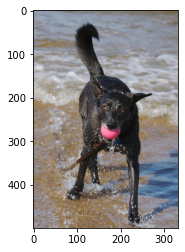

Greedy: black dog is running through the water


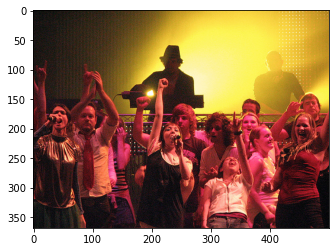

Greedy: crowd of people are sitting at tables waving american flags


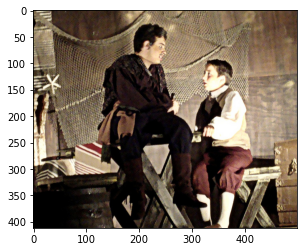

Greedy: man in white robe and tie is sitting on bench


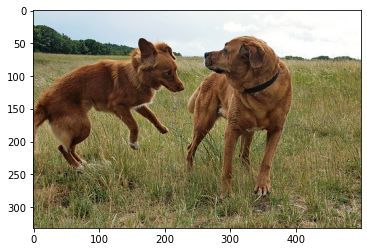

Greedy: two dogs are playing together in the grass


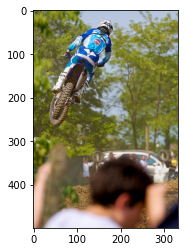

Greedy: man in red shirt is rock climbing


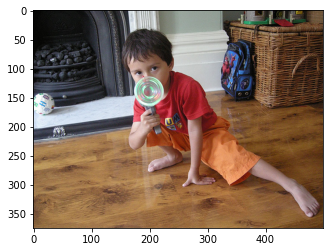

Greedy: young boy in blue shirt and blue jeans is playing with toy


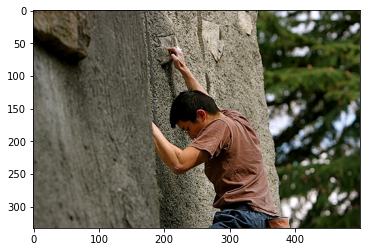

Greedy: man in red shirt climbs rock wall


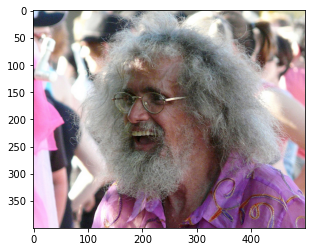

Greedy: man in black shirt and tie is holding up peace sign


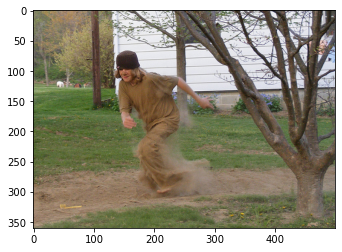

Greedy: dog is jumping up to catch tennis ball in the grass


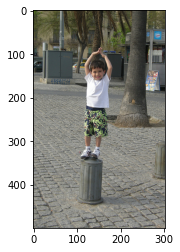

Greedy: woman in black and white striped shirt is standing on the sidewalk


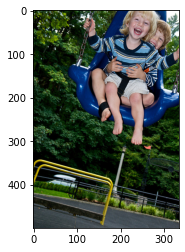

Greedy: young girl in pink shirt is hanging upside down from rope swing


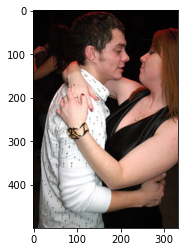

Greedy: woman with her hair in her hair is smiling


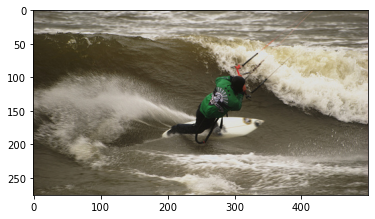

Greedy: man in black wetsuit is surfing on the shore


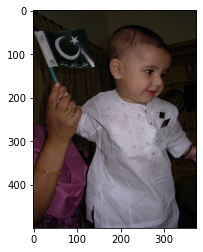

Greedy: young boy wearing blue shirt is holding green and blue colored


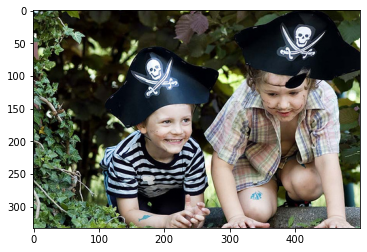

Greedy: little girl in pink dress is playing with ribbon


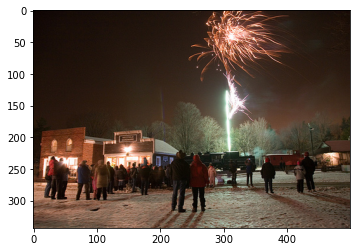

Greedy: two people are sitting on bench at night


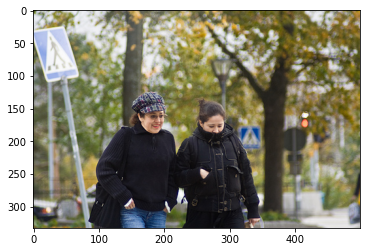

Greedy: man in black jacket and tie is standing in front of brick wall


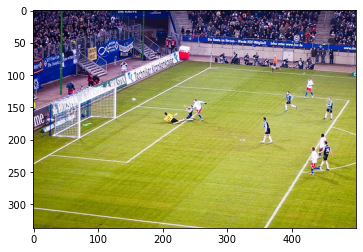

Greedy: three men are playing rugby


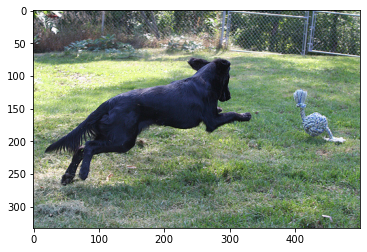

Greedy: black dog is running through the grass


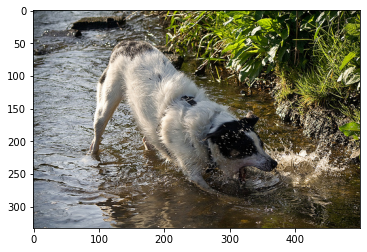

Greedy: dog is jumping over log in the water


In [78]:
import random
for i in range(20):
    z = random.randint(0, len(encoding_test))
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedySearch(image))

<div class="alert alert-success">
<h2>Generate First 20 Images</h2>
</div>

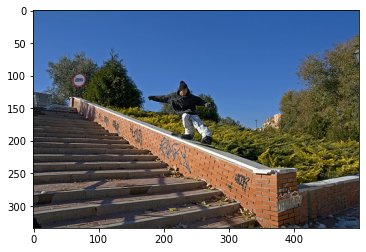

Greedy: man and woman sit on bench


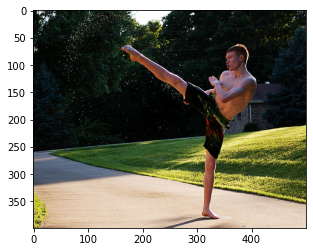

Greedy: young boy in red shirt and blue jeans is jumping in the air


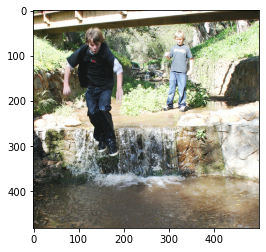

Greedy: two children are playing in water fountain


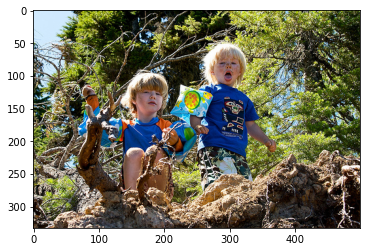

Greedy: girl in red shirt and blue jeans is standing in the grass


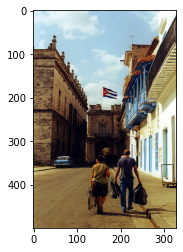

Greedy: man in black shirt and jeans is walking down sidewalk


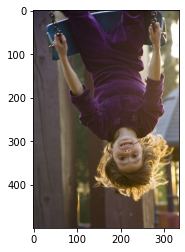

Greedy: two children are playing on playground


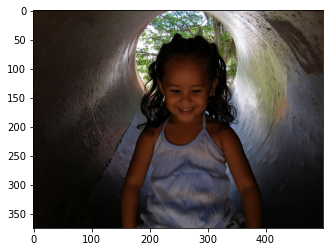

Greedy: two girls are sitting on top of an amusement park ride


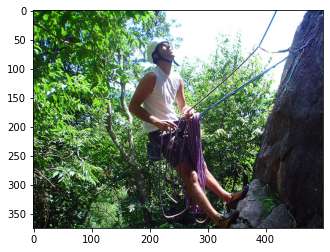

Greedy: man in red shirt and jeans is standing on top of rock


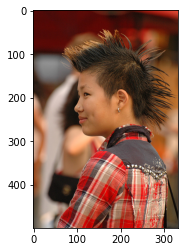

Greedy: woman with black hair is wearing black sweater and carrying purse


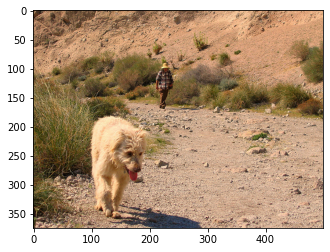

Greedy: two dogs are running on the grass


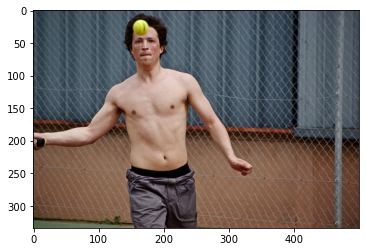

Greedy: boy in blue shirt hits ball with his arms out


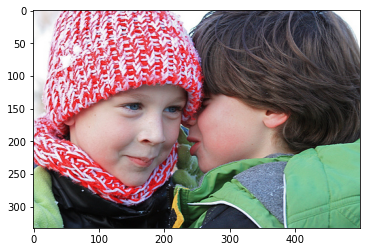

Greedy: woman with her hair in her hair


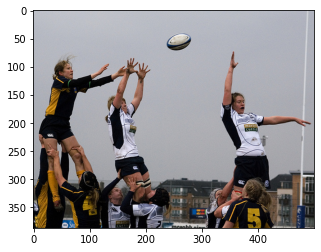

Greedy: two men in soccer uniforms are playing soccer


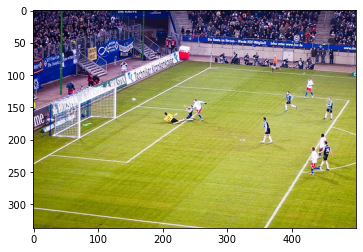

Greedy: three men are playing rugby


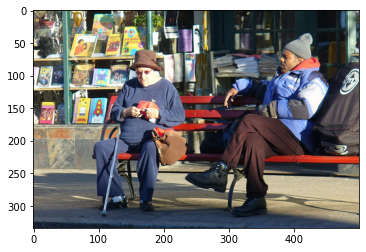

Greedy: man in black shirt and jeans is standing in front of building


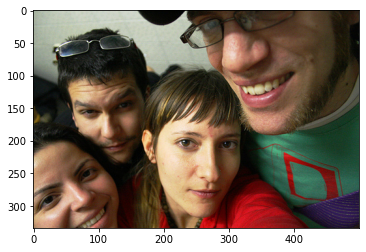

Greedy: woman with her hair in her hair


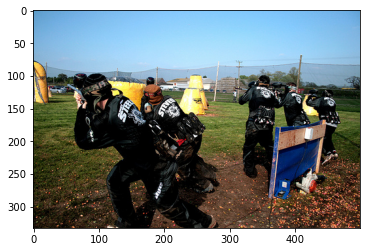

Greedy: group of people are standing in line on the ground


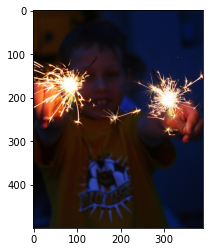

Greedy: two people are sitting on boat in front of large wooden structure


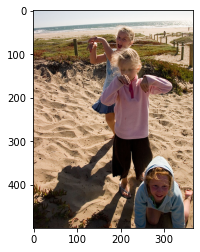

Greedy: little girl in pink shirt is running on the beach


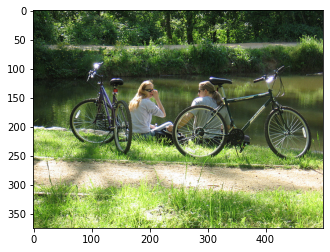

Greedy: man riding bike sideways down hill


In [70]:
for z in range(20):
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedySearch(image))